In [41]:
def data():
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.preprocessing import timeseries_dataset_from_array
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
    import tensorflow as tf
    from hyperas.distributions import choice, uniform
    from hyperas import optim

    df = pd.read_csv("differenced_data.csv")
    df.drop(["Date"], axis=1, inplace=True)

    train_df = df[0:int(len(df)*.7)]
    val_df = df[int(len(df)*.7):int(len(df)*.9)]
    # test_df = df[int(len(df)*.9):]

    # train_len = int(len(train_df)*.9)

    # train_df = train_df[:train_len]
    # val_df = train_df[train_len:]

    scaler = StandardScaler()
    scaler.fit(train_df)

    train_scaled = scaler.transform(train_df)
    val_scaled = scaler.transform(val_df)
    # test_scaled = scaler.transform(test_df)

    input_width = 6
    label_width = 6
    shift = 1
    label_columns = None

    column_indeces = {name: i for i, name in enumerate(train_df.columns)}
    if label_columns is not None:
        label_column_indeces = {name: i for i, name in enumerate(label_columns)}

    window_size = input_width + shift

    input_slice = slice(0, input_width)
    input_indeces = np.arange(window_size)[input_slice]

    label_start = window_size - label_width
    label_slice = slice(label_start, None)
    label_indeces =  np.arange(window_size)[label_slice]

    def split_window(features):
        inputs = features[:, input_slice, :]
        labels = features[:, label_slice, :]
        if label_columns:
            labels = tf.stack([labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

        inputs.set_shape([None, input_width, None])
        labels.set_shape([None, label_width, None])

        return inputs, labels

    def make_dataset(data):
        data = np.array(data, dtype=np.float64)
        dset = timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        dset = dset.map(split_window)
        return dset

    model_train = make_dataset(train_scaled)
    model_val = make_dataset(val_scaled)

    # # X_train = np.array(list(model_train.as_numpy_iterator()))[:,0]
    # # X_train  = np.array(list(model_train.as_numpy_iterator()))[:,0].flatten()
    # X_train = np.array(list(model_train.unbatch().as_numpy_iterator()))[:,0]
    # # #594 batches with each batch containing an array of (32,6,12)

    # # y_train = np.array(list(model_train.as_numpy_iterator()))[:,1]
    # # y_train  = np.array(list(model_train.as_numpy_iterator()))[:,1].flatten()
    # y_train = np.array(list(model_train.unbatch().as_numpy_iterator()))[:,1]

    # # X_val = np.array(list(model_val.as_numpy_iterator()))[:,0]
    # # X_val = np.array(list(model_val.as_numpy_iterator()))[:,0].flatten()
    # X_val = np.array(list(model_val.unbatch().as_numpy_iterator()))[:,0]

    # # y_val = np.array(list(model_val.as_numpy_iterator()))[:,1]
    # # y_val = np.array(list(model_val.as_numpy_iterator()))[:,1].flatten()
    # y_val = np.array(list(model_val.unbatch().as_numpy_iterator()))[:,1]

    train_data = np.array(train_scaled)
    val_data = np.array(val_scaled)

    # train_len = int(len(train_data)*.9)

    # train_data = train_data[:train_len]
    # val_data = train_data[train_len:]


    # end_index = train_data[:train_len]

    # print(len(train_data))

    train_data = timeseries_dataset_from_array(
                                            data = train_data,
                                            targets=None, 
                                            sequence_length=7, 
                                            shuffle=True, 
                                            batch_size=32)

    val_data = timeseries_dataset_from_array(
                                            data = val_data,
                                            targets = None,
                                            sequence_length = 7,
                                            shuffle = True,
                                            batch_size = 32)



    # dataset.inputs.set_shape(None, 6, None)

    train_dataset = train_data.map(split_window)
    val_dataset = val_data.map(split_window)

    return train_dataset, val_dataset

In [42]:
# def create_model(train_dataset, val_dataset):

#     from sklearn.model_selection import train_test_split
#     from sklearn.metrics import mean_squared_error
#     from sklearn.preprocessing import StandardScaler

#     from tensorflow.keras.models import Sequential
#     from tensorflow.keras.layers import Dense
#     from tensorflow.keras.layers import LSTM
#     import tensorflow as tf

#     model = Sequential()
#     model.add(LSTM(16),
#             return_sequences=True 
#            # ,input_shape=(X_train.shape[1], X_train.shape[2]))
#         #    , batch_input_shape=(None, X_train.shape[1], X_train.shape[2])
#             )

#     model.add(Dense(16, activation = 'relu'))
#     model.add(Dense(12))
#     model.compile(loss="mae", 
#                 optimizer="adam", 
#                 metrics=["mae", "mse"]
#                 )
#     e_stop =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

#     # train_len = int(len(train_dataset)*.9)

#     # result = model.fit(train_dataset[:train_len], epochs=25, batch_size=60, validation_data=train_dataset[:train_len], verbose=2, callbacks = [e_stop], shuffle=False)

#     result = model.fit(train_dataset, epochs=25, batch_size=60, validation_data=val_dataset, verbose=2, callbacks = [e_stop], shuffle=False)

#     # print(result.history)

#     validation_loss = np.amin(result.history['val_loss'])
#     plt.plot(result.history["loss"], label="train")
#     plt.plot(result.history["val_loss"], label="val")
#     plt.legend(loc="upper right")
#     plt.title('Training Loss vs. Validation Loss')
#     plt.show()
#     print('Best Validation loss of epoch:', validation_loss)
#     return {'loss': validation_loss, 'status': STATUS_OK, 'model':model}

In [43]:
def create_model(train_dataset, val_dataset):

    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
    from tensorflow.keras.layers import LSTM
    import tensorflow as tf
    import matplotlib.pyplot as plt

    model = Sequential()
    model.add(LSTM({{choice([4, 8, 16, 20])}},
            return_sequences=True 
           # ,input_shape=(X_train.shape[1], X_train.shape[2]))
        #    , batch_input_shape=(None, X_train.shape[1], X_train.shape[2])
            ))



    model.add(Dense({{choice([10, 12])}}, activation='relu'))

    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Dense(12))

    model.add(Activation('tanh'))

    model.compile(loss="mae", 
                optimizer="adam", 
                metrics=["mae", "mse"]
                )

    e_stop =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")

    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/saved_checkpoints/multi_parameter_check_2.hdf5',
                                    monitor='val_loss',
                                    verbose=2,
                                    save_best_only=True)


    # train_len = int(len(train_dataset)*.9)

    # result = model.fit(train_dataset[:train_len], epochs=25, batch_size=60, validation_data=train_dataset[:train_len], verbose=2, callbacks = [e_stop], shuffle=False)

    result = model.fit(train_dataset, validation_data=val_dataset, epochs={{choice([15, 20, 40])}}, batch_size={{choice([20, 60, 80, 120])}}, callbacks = [e_stop, checkpointer], verbose=2, shuffle=False)

    # print(result.history)

    validation_loss = np.amin(result.history['val_loss'])
    print('Best Validation loss of epoch:', validation_loss)
    plt.plot(result.history["loss"], label="train")
    plt.plot(result.history["val_loss"], label="val")
    plt.legend(loc="upper right")
    plt.title('Training Loss vs. Validation Loss')
    plt.show()
    return {'loss': validation_loss, 'status': STATUS_OK, 'model':model}

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.preprocessing import timeseries_dataset_from_array
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import mean_squared_error
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Den

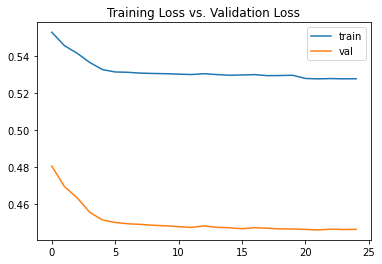

Epoch 1/15
  5%|▌         | 1/20 [01:52<35:37, 112.50s/trial, best loss: 0.4458257257938385]WARNING:tensorflow:Layer lstm_42 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48398, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5528 - mae: 0.5528 - mse: 1.0004 - val_loss: 0

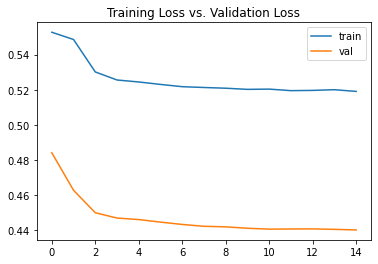

Epoch 1/20
 10%|█         | 2/20 [02:57<29:28, 98.26s/trial, best loss: 0.4399082660675049]WARNING:tensorflow:Layer lstm_43 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48402, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5536 - mae: 0.5536 - mse: 1.0015 - val_loss: 0.

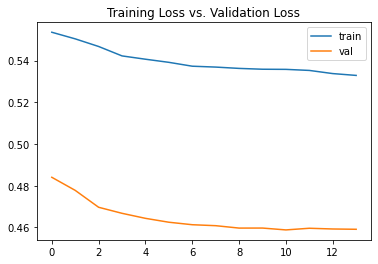

Epoch 1/20
 15%|█▌        | 3/20 [04:00<24:51, 87.74s/trial, best loss: 0.4399082660675049]WARNING:tensorflow:Layer lstm_44 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.47067, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5507 - mae: 0.5507 - mse: 0.9873 - val_loss: 0.

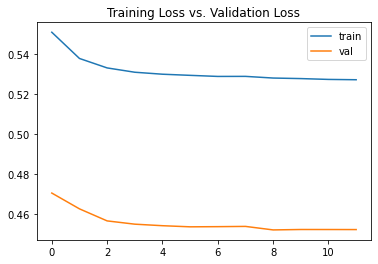

Epoch 1/15
 20%|██        | 4/20 [04:48<20:10, 75.64s/trial, best loss: 0.4399082660675049]WARNING:tensorflow:Layer lstm_45 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.47069, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5502 - mae: 0.5502 - mse: 0.9929 - val_loss: 0.

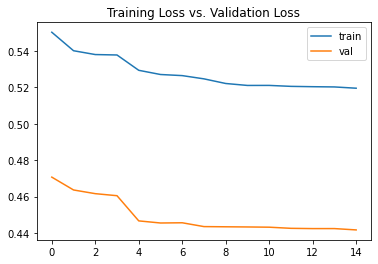

Epoch 1/40
 25%|██▌       | 5/20 [06:02<18:47, 75.18s/trial, best loss: 0.4399082660675049]WARNING:tensorflow:Layer lstm_46 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48296, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 6s - loss: 0.5533 - mae: 0.5533 - mse: 1.0007 - val_loss: 0.

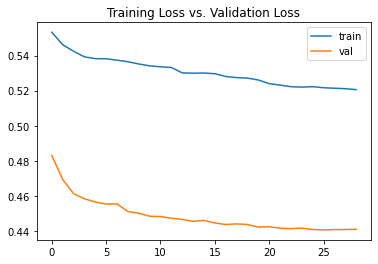

Epoch 1/15
 30%|███       | 6/20 [08:17<21:44, 93.18s/trial, best loss: 0.4399082660675049]WARNING:tensorflow:Layer lstm_47 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48401, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 7s - loss: 0.5538 - mae: 0.5538 - mse: 1.0022 - val_loss: 0.

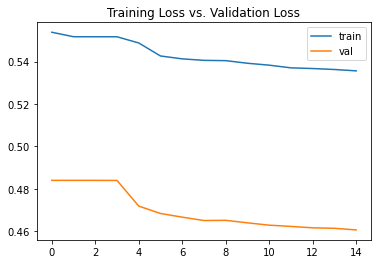

Epoch 1/40
 35%|███▌      | 7/20 [09:34<19:09, 88.41s/trial, best loss: 0.4399082660675049]WARNING:tensorflow:Layer lstm_48 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.45313, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 6s - loss: 0.5406 - mae: 0.5406 - mse: 0.9576 - val_loss: 0.

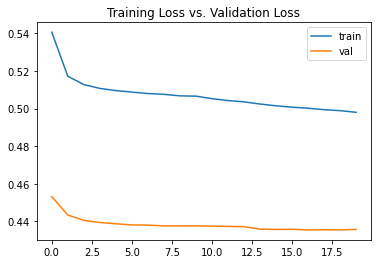

Epoch 1/15
 40%|████      | 8/20 [11:13<18:15, 91.28s/trial, best loss: 0.4354309141635895]WARNING:tensorflow:Layer lstm_49 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48377, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5528 - mae: 0.5528 - mse: 1.0010 - val_loss: 0.

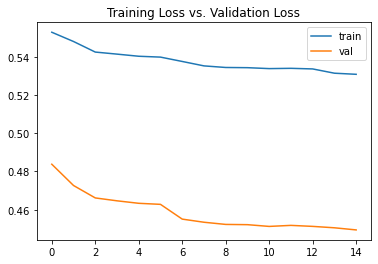

Epoch 1/20
 45%|████▌     | 9/20 [12:29<15:57, 87.02s/trial, best loss: 0.4354309141635895]WARNING:tensorflow:Layer lstm_50 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48401, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5531 - mae: 0.5531 - mse: 1.0014 - val_loss: 0.

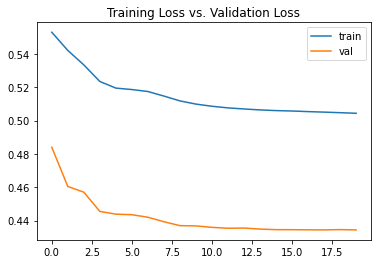

Epoch 1/20
 50%|█████     | 10/20 [14:06<14:58, 89.90s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_51 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48400, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5530 - mae: 0.5530 - mse: 1.0014 - val_loss: 0

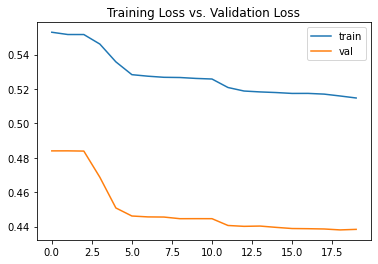

Epoch 1/20
 55%|█████▌    | 11/20 [15:49<14:03, 93.74s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_52 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48399, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5537 - mae: 0.5537 - mse: 1.0016 - val_loss: 0

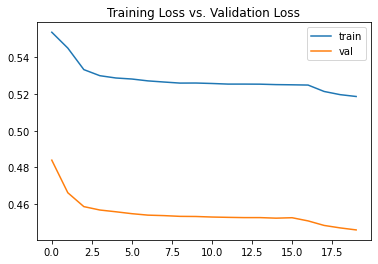

Epoch 1/20
 60%|██████    | 12/20 [17:15<12:12, 91.59s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_53 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.47239, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 6s - loss: 0.5497 - mae: 0.5497 - mse: 0.9928 - val_loss: 0

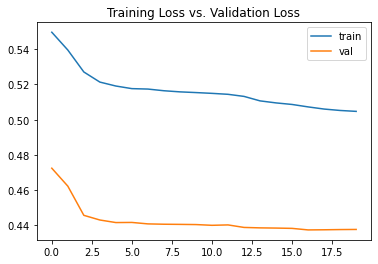

Epoch 1/15
 65%|██████▌   | 13/20 [18:47<10:40, 91.47s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_54 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.47898, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5523 - mae: 0.5523 - mse: 0.9975 - val_loss: 0

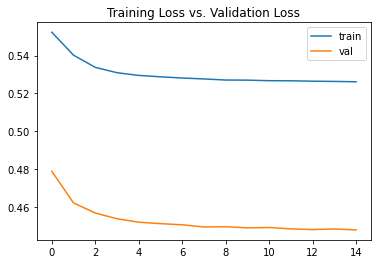

Epoch 1/20
 70%|███████   | 14/20 [19:52<08:21, 83.54s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_55 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48398, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5533 - mae: 0.5533 - mse: 1.0008 - val_loss: 0

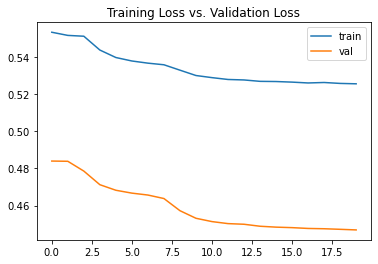

Epoch 1/20
 75%|███████▌  | 15/20 [21:12<06:52, 82.59s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_56 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48394, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5542 - mae: 0.5542 - mse: 1.0014 - val_loss: 0

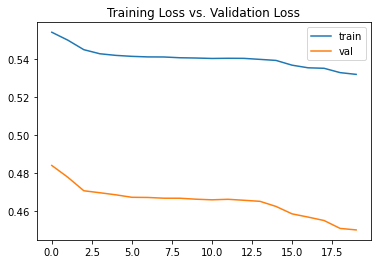

Epoch 1/20
 80%|████████  | 16/20 [22:39<05:36, 84.07s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_57 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48403, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5542 - mae: 0.5542 - mse: 1.0029 - val_loss: 0

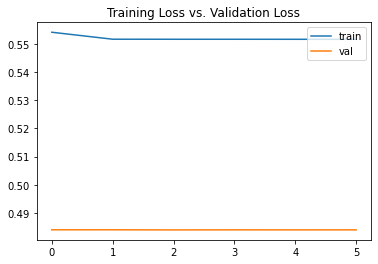

Epoch 1/15
 85%|████████▌ | 17/20 [23:10<03:23, 67.91s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_58 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48284, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5533 - mae: 0.5533 - mse: 1.0002 - val_loss: 0

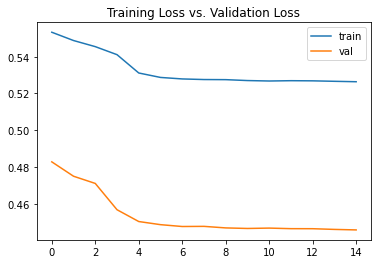

Epoch 1/15
 90%|█████████ | 18/20 [24:33<02:24, 72.44s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_59 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48402, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 4s - loss: 0.5540 - mae: 0.5540 - mse: 1.0031 - val_loss: 0

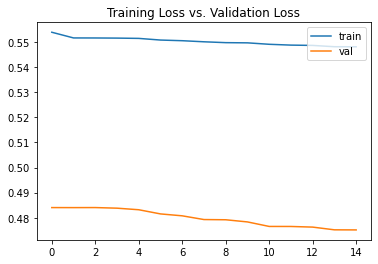

Epoch 1/20
 95%|█████████▌| 19/20 [25:43<01:11, 71.66s/trial, best loss: 0.4343929886817932]WARNING:tensorflow:Layer lstm_60 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Epoch 00001: val_loss improved from inf to 0.48078, saving model to saved_models/saved_checkpoints/multi_parameter_check_2.hdf5
594/594 - 5s - loss: 0.5528 - mae: 0.5528 - mse: 1.0001 - val_loss: 0

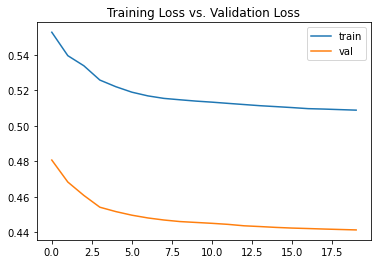

100%|██████████| 20/20 [27:31<00:00, 82.56s/trial, best loss: 0.4343929886817932]
Evaluation of best performing model:
170/170 [==============================] - 1s 6ms/step - loss: 0.4344 - mae: 0.4344 - mse: 0.5902
[0.4343929588794708, 0.43439292907714844, 0.5902499556541443]
Best Performing Model Hyper-Parameters:
{'Dense': 0, 'Dropout': 0.20946774700477522, 'LSTM': 3, 'batch_size': 0, 'epochs': 1}


In [44]:
if __name__ == '__main__':

    from hyperas import optim
    from tensorflow.keras.models import Sequential
    from hyperopt import Trials, tpe
    from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
    import tensorflow as tf

    best_run, best_model = optim.minimize(model=create_model,
                                            data=data,
                                            algo=tpe.suggest,
                                            max_evals=20,
                                            trials=Trials(),
                                            notebook_name = 'HyperParameter_Tuning_v3')
                                            
    train_dataset, val_dataset = data()
    print('Evaluation of best performing model:')
    print(best_model.evaluate(val_dataset))
    print("Best Performing Model Hyper-Parameters:")
    print(best_run)

In [5]:
model_45 = best_model

In [6]:
model_45.save('saved_models/loss_45')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/loss_45/assets


In [11]:
model_42 = best_model

In [12]:
model_42.save('saved_models/loss_42')

INFO:tensorflow:Assets written to: saved_models/loss_42/assets


In [30]:
model_42.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 6, 16)             1856      
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 6, 12)             204       
Total params: 2,060
Trainable params: 2,060
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_428 = best_model
model_42.save('saved_models/loss_42')

INFO:tensorflow:Assets written to: saved_models/loss_428/assets


In [35]:
model_multi_parameter_437 = best_model

In [36]:
model_multi_parameter_437.save('saved_models/model_multi_parameter_437')

INFO:tensorflow:Assets written to: saved_models/model_multi_parameter_437/assets


In [40]:
model_multi_parameter_437.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 6, 8)              672       
_________________________________________________________________
dense_61 (Dense)             (None, 6, 12)             108       
_________________________________________________________________
dropout_30 (Dropout)         (None, 6, 12)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 6, 12)             156       
_________________________________________________________________
activation_25 (Activation)   (None, 6, 12)             0         
Total params: 936
Trainable params: 936
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_multi_parameter_434 = best_model
model_multi_parameter_434.save('saved_models/model_multi_parameter_434')


INFO:tensorflow:Assets written to: saved_models/model_multi_parameter_434/assets


In [46]:
model_multi_parameter_434.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 6, 20)             2640      
_________________________________________________________________
dense_89 (Dense)             (None, 6, 10)             210       
_________________________________________________________________
dropout_44 (Dropout)         (None, 6, 10)             0         
_________________________________________________________________
dense_90 (Dense)             (None, 6, 12)             132       
_________________________________________________________________
activation_39 (Activation)   (None, 6, 12)             0         
Total params: 2,982
Trainable params: 2,982
Non-trainable params: 0
_________________________________________________________________
